In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [15]:
import math
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product

from scipy.stats import pearsonr
from importlib import reload

from lib import sketches
from lib import visualization_utils
from lib import encoders
from lib import pacha_sketch
reload(sketches)
reload(visualization_utils)
reload(encoders)
reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover
from lib.pacha_sketch import PachaSketch, CMParameters, BFParameters

In [3]:
df = pd.read_parquet("data/normal_3d_100k.parquet")

In [16]:
cm_params = CMParameters(width=300000, depth=5)
bf_params = BFParameters(n_values=len(df), p=0.01)

In [17]:
pacha_sketch = PachaSketch(dimensions=3, base=5, levels=4, cm_params=cm_params, bf_params=bf_params, sketch_type=["bf", "cm", "cm", "cm"])    

In [19]:
pacha_sketch.update_data_frame(df)

# Evaluation

In [20]:
levels = 4
base = 5
dimensions = 3

# Create queries
lower_bound = 4800
upper_bound = 5200 - base ** (levels-1)
n_samples = 20

queries = []

for l in range(levels):
    l_queries = []
    for i in range(n_samples):
        start = np.random.randint(lower_bound, upper_bound)
        end = start + base**l - 1
        query = [(int(start), int(end))] * dimensions
        l_queries.append(query)
    queries.append(l_queries)

In [ ]:
base = 5
dimensions = 3
pacha_sketch = pacha_sketch

true_results = []
estimates = []
absolute_errors = []
relative_errors = []

for l in range(levels):
    l_true_results = []
    l_estimates = []
    l_absolute_errors = []
    l_relative_errors = []

    for i in range(n_samples):
        query = queries[l][i]

        true_result = df.query(" and ".join([f"d_{i} >= {query[i][0]} and d_{i} <= {query[i][1]}" for i in range(dimensions)])).shape[0]
        estimate = pacha_sketch.query(query)

        l_true_results.append(true_result)
        l_estimates.append(int(estimate))

        l_absolute_errors.append(int(abs(true_result - estimate)))
        if true_result != 0:
            l_relative_errors.append(abs(true_result - estimate) / true_result)
        else:
            l_relative_errors.append(abs(true_result - estimate))
    
    print(f"level compleated: {l}")
    true_results.append(l_true_results)
    estimates.append(l_estimates)
    absolute_errors.append(l_absolute_errors)
    relative_errors.append(l_relative_errors)

    
    flat_true_results = np.array(true_results).flatten()
    flat_estimates = np.array(estimates).flatten()
    flat_relative_errors = np.array(relative_errors).flatten()
    flat_absolute_errors = np.array(absolute_errors).flatten()


level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


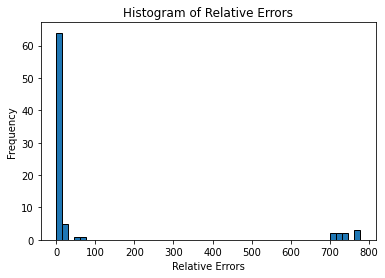

In [ ]:
# Plot the histogram
plt.hist(flat_relative_errors, bins=50, edgecolor='black')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors')
plt.show()

In [33]:
np.argmax(flat_relative_errors)

np.int64(57)

In [37]:
i = np.argmax(flat_relative_errors)

print(f"True result: {flat_true_results[i]}")
print(f"Estimate: {flat_estimates[i]}")
print(f"Relative error: {flat_relative_errors[i]}")
print(f"Absolute error: {flat_absolute_errors[i]}")

True result: 0
Estimate: 778
Relative error: 778.0
Absolute error: 778


In [41]:
results = np.asarray([flat_true_results, flat_estimates, flat_relative_errors, flat_absolute_errors]).T

In [43]:
sorted_results = results[results[:, 0].argsort()[::-1]]

In [51]:
query_sizes = []

for l in range(levels):
    query_sizes.append([l] * n_samples)

query_sizes = np.array(query_sizes).flatten()

In [52]:
data = {
    'Query Size': query_sizes,
    'True Results': flat_true_results,
    'Estimates': flat_estimates,
    'Relative Errors': flat_relative_errors,
    'Absolute Errors': flat_absolute_errors
}

df_results = pd.DataFrame(data)
df_results = df_results.sort_values(by='Relative Errors', ascending=True)
df_results.head()

,Query Size,True Results,Estimates,Relative Errors,Absolute Errors
0,0,0,0,0.0,0
1,0,0,0,0.0,0
2,0,0,0,0.0,0
3,0,0,0,0.0,0
4,0,0,0,0.0,0


In [53]:
print(df_results.to_string())


    Query Size  True Results  Estimates  Relative Errors  Absolute Errors
0            0             0          0         0.000000                0
1            0             0          0         0.000000                0
2            0             0          0         0.000000                0
3            0             0          0         0.000000                0
4            0             0          0         0.000000                0
5            0             0          0         0.000000                0
7            0             0          0         0.000000                0
8            0             0          0         0.000000                0
14           0             0          0         0.000000                0
9            0             0          0         0.000000                0
11           0             0          0         0.000000                0
12           0             0          0         0.000000                0
15           0             0          

In [44]:
sorted_results

array([[4.69560000e+04, 4.69620000e+04, 1.27779198e-04, 6.00000000e+00],
       [4.15650000e+04, 4.32790000e+04, 4.12366173e-02, 1.71400000e+03],
       [3.80490000e+04, 3.96390000e+04, 4.17882205e-02, 1.59000000e+03],
       [3.65070000e+04, 6.01320000e+04, 6.47136166e-01, 2.36250000e+04],
       [3.45770000e+04, 5.85640000e+04, 6.93727044e-01, 2.39870000e+04],
       [3.00840000e+04, 3.00860000e+04, 6.64805212e-05, 2.00000000e+00],
       [2.93020000e+04, 5.33180000e+04, 8.19602757e-01, 2.40160000e+04],
       [2.82860000e+04, 5.25190000e+04, 8.56713569e-01, 2.42330000e+04],
       [2.20350000e+04, 2.36910000e+04, 7.51531654e-02, 1.65600000e+03],
       [2.05270000e+04, 4.48170000e+04, 1.18331953e+00, 2.42900000e+04],
       [1.48540000e+04, 1.63500000e+04, 1.00713612e-01, 1.49600000e+03],
       [1.26130000e+04, 3.68430000e+04, 1.92103385e+00, 2.42300000e+04],
       [4.55600000e+03, 2.84160000e+04, 5.23705004e+00, 2.38600000e+04],
       [1.89400000e+03, 2.58120000e+04, 1.26282999e

In [28]:
r = 500
d = 3

space_size = r ** d

b = 5
l = 1

level_space = (r // (b ** l)) ** d

print(f"Space size: {space_size}")
print(f"Level space: {level_space}")
print(f"Ratio: {space_size / level_space}")

Space size: 125000000
Level space: 1000000
Ratio: 125.0
